<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Merge-Metadata-to-Final-Model" data-toc-modified-id="Merge-Metadata-to-Final-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Merge Metadata to Final Model</a></span></li><li><span><a href="#Apply-strata-randomization-to-eligible-followers" data-toc-modified-id="Apply-strata-randomization-to-eligible-followers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Apply strata randomization to eligible followers</a></span></li><li><span><a href="#Power-Analysis" data-toc-modified-id="Power-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Power Analysis</a></span></li><li><span><a href="#Get-users-based-on-power-analysis" data-toc-modified-id="Get-users-based-on-power-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get users based on power analysis</a></span></li></ul></div>

# Packages

In [17]:
import pandas as pd
import os 
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import concurrent.futures
import seaborn as sns
import random 


np.random.seed(416)
random.seed(416)

# Merge Metadata to Final Model

In [ ]:
# Takes around 20m

print("Making data file")

print("Reading in data")
df1 = pd.read_csv("metadata_blog_tweet_merge_CLEAN_ND.csv")
df2 = pd.read_csv("filtered_parsed_tweetsND22.csv", dtype={'user_id':'object'})
hydrated_main = pd.read_csv("HydratedMain_ND22_t1_t3_v2___10.02.2023__22.42.29__START0_END-1_merged.csv", dtype={'user_id':'object'})
hydrated_follower = pd.read_csv("HydratedFollowers_ND22_t1_t3_v2___10.02.2023__14.23.39__START0_END-1_merged.csv", dtype={'user_id':'object'})
mod = pd.read_csv("s2_mar23_oct23_ideoY_final_mod.csv", dtype={'main':'object', 'followers_id':'object'})

print("Getting days since tweet")
hydrated_follower['last_tweet_date'] = pd.to_datetime(hydrated_follower['last_tweet_date'], errors='coerce', utc=True)
comparison_date_utc = pd.Timestamp('2023-10-02 00:00:00', tz='UTC')
hydrated_follower['days_since_last_tweet'] = (comparison_date_utc - hydrated_follower['last_tweet_date']).dt.days
hydrated_follower['days_since_last_tweet'] = hydrated_follower['days_since_last_tweet'].clip(lower=0)
hydrated_follower = hydrated_follower.rename(columns = {'username':'follower_username'})

print("Merging data")
pf_merged = pd.merge(df1, df2, left_on=['misinfo_url'], right_on=['misinfo_match'], indicator='pf_merge', how='inner')
pf_merged = pf_merged.rename(columns = {'url':'pf_url'})
display(pf_merged['pf_merge'].value_counts())
pf_merged.to_csv("merged_politifact_tweet_data.csv")

hydrated_main = hydrated_main.rename(columns = {'username':'spreader_username'})
pf_merged = pd.merge(pf_merged, hydrated_main, left_on=['user_id'], right_on=['user_id'], indicator="merge_hydrated_spreader", how='left')

display(pf_merged['merge_hydrated_spreader'].value_counts())

pf_merged = pd.merge(pf_merged, mod, left_on=['user_id'], right_on=['main'], indicator="merge_model_data", how='left')
display(pf_merged['merge_model_data'].value_counts())

pf_merged = pd.merge(pf_merged, hydrated_follower, left_on=['user_id'], right_on=['user_id'], indicator="merge_hydrated_follower", how='left')
display(pf_merged['merge_hydrated_follower'].value_counts())
print("Data merged")

pf_merged = pf_merged.dropna(subset=['main', 'followers_id'])
pf_merged = pf_merged.drop_duplicates(subset=['main', 'followers_id'])


print("Writing to csv")
pf_merged.to_csv("all_edge_data.csv")
print("Done")

# Apply strata randomization to eligible followers

In [15]:
import pandas as pd

def read_data(file_path):
    """
    Read data from a CSV file and return a DataFrame.
    """
    print("reading csv")
    df = pd.read_csv(file_path, dtype={"followers_id": 'object', 'main': 'object'})
    return df

def apply_inclusion_criteria(tdf, days_since_tweet, min_followers_assigned_spreader, filter_for_non_recip=False):
    """
    Apply inclusion criteria to the DataFrame.
    """
    df = tdf.query(f"days_since_last_tweet < {days_since_tweet}")
    if filter_for_non_recip:
        df = df.query("recip==0")
    df['followers_assigned_spreader'] = df.groupby(by=['main'])['followers_id'].transform(lambda x: len(set(x)))
    df = df.query(f"followers_assigned_spreader >= {min_followers_assigned_spreader}")
    return df 

def define_strata(df, strata_columns):
    """
    Define strata for the DataFrame.
    """
    for x in strata_columns:
        df[f"{x}_strata"] = pd.qcut(df[x], 2, labels=False, duplicates='drop')
    strata_cols = [x for x in df.columns if "strata" in x or "is_liberal" in x]
    df['block'] = df[strata_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    return df

def strata_randomization(df, ego_col, alter_col, strata_col, random_state=416):
    """
    Strata-based sequential network randomization algorithm.
    
    The idea is to select a pair (control, treatment) of alters for an ego where both alters are from the same strata, 
    attempting to balance strata of the resultant sample. 
    
    Returns:
        A dict with keys `total_sample`, `control`, `treatment` where values are an array of pandas indicies of the original dataframe. 
        
    """
    block_dict = {}
    for block in df[strata_col].unique():
        block_dict[block] = 0

    total_sample = []
    control = []
    treatment = []

    egos = set(df[ego_col].values)

    for ego in egos:
        sdf = df.query("{}=='{}'".format(ego_col, ego))  
        sdf = sdf.loc[~sdf.index.isin(total_sample)]
        random_blocks = sorted(block_dict, key=block_dict.get, reverse=False)
        for block_val in random_blocks:
            block_sdf = sdf[sdf[strata_col] == block_val] 
            if len(block_sdf) < 2:
                continue
            else:
                sample = list(block_sdf.sample(2, random_state=random_state).index)
                total_sample.extend(sample)
                control.append(sample[0])
                treatment.append(sample[1])
                block_dict[block_val] += 2
                break
    return {'total_sample':total_sample, 'control':control, 'treatment':treatment}
 

def gen_sample(df, ego_col, alter_col, strata_col, output_file):
    """
    Generate sample using strata randomization and save to CSV.
    """
    print("Generating sample")
    sample = strata_randomization(df, ego_col, alter_col, strata_col)
    total_indices = sample['total_sample']
    control_indices = sample['control']
    treatment_indices = sample['treatment']
    
    to_sample = df[df.index.isin(total_indices)]
    to_sample['edge_no'] = pd.factorize(to_sample['spreader_username'])[0]
    to_sample['idx'] = to_sample.index
    to_sample['treat'] = to_sample['idx'].apply(lambda x: 1 if x in treatment_indices else 0)
    print("Saving sample")
    to_sample.to_csv(output_file)
    return to_sample
    

file_path = "all_edge_data.csv"
df = read_data(file_path)
df = apply_inclusion_criteria(df, days_since_tweet=21, 
                              min_followers_assigned_spreader=2,
                             filter_for_non_recip = True)
strata_columns = ['t2_follower_following_count', 't2_follower_tweet_count', 'n_spreader_following']
df = define_strata(df, strata_columns)
to_sample = gen_sample(df, ego_col='main', alter_col='followers_id', strata_col='block', output_file="strata_all_ties_for_pow.csv")

reading csv


/Users/jashkina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (9,13,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-15-feb88e3e362c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['followers_assigned_spreader'] = df.groupby(by=['main'])['followers_id'].transform(lambda x: len(set(x)))


Generating sample


<ipython-input-15-feb88e3e362c>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_sample['edge_no'] = pd.factorize(to_sample['spreader_username'])[0]
<ipython-input-15-feb88e3e362c>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_sample['idx'] = to_sample.index
<ipython-input-15-feb88e3e362c>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Saving sample


# Power Analysis

A laboratory experiment (Kaiser et al. (2022)) asked users to imagine that somebody the participant followed posted misinformation. Then the study asked participant's to rate their intentions to unfollow that individual on a scale of 1-6, with 1 being unfollowing "does not at all apply" and 6 being "does fully apply". Summing the percentage of respondents who answered 4-6 is a rough measure of the percentage of respondent's who would be more likely than not to unfollow. That sum is ~19%. We then 'discount' this effect size by different values.

21 DAYS


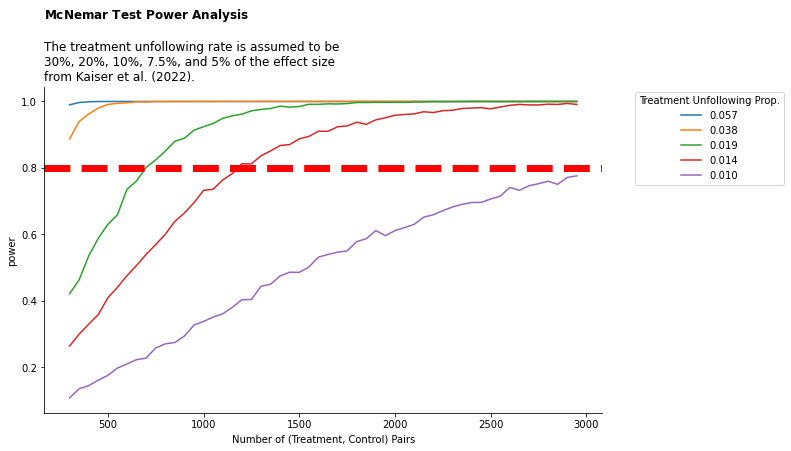

   treatment_prop  N_pairs treatment_prop_label
0         0.01425     1200                0.014
1         0.01900      700                0.019
2         0.03800      300                0.038
3         0.05700      300                0.057
28 DAYS


<Figure size 432x288 with 0 Axes>

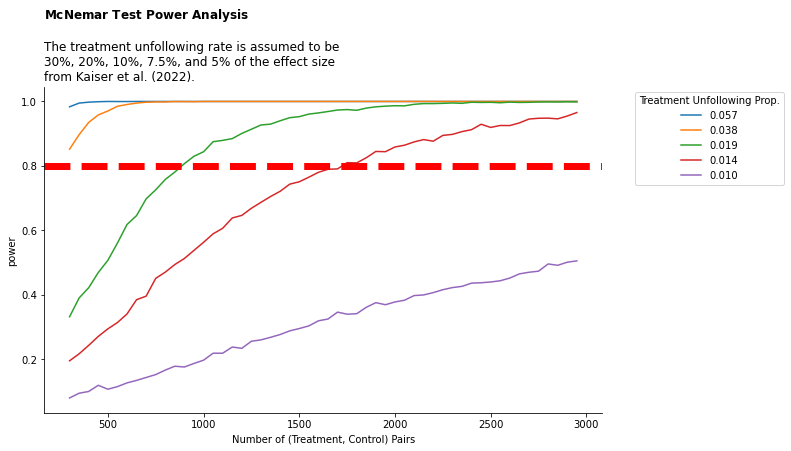

   treatment_prop  N_pairs treatment_prop_label
0         0.01425     1750                0.014
1         0.01900      900                0.019
2         0.03800      300                0.038
3         0.05700      300                0.057


<Figure size 432x288 with 0 Axes>

In [23]:
def run_power_analysis(params):
    """Run power analysis and plot the results."""
    
    # Default params to be overwritten by `params` dict
    control_prop = params.get('control_prop', 0.01)
    treatment_props = params.get('treatment_prop', [0.20*0.19, 0.10*0.19, 0.05*0.19])
    N_values = params.get('N_values', range(500, 5050, 50))

    n_simulations = params.get('n_simulations', 1000)
    
    n_jobs = -1  # 
    
    all_records = []
    
    for treatment_prop in treatment_props:
        results = Parallel(n_jobs=n_jobs)(
            delayed(estimate_power)(N, control_prop, treatment_prop, 0.05, n_simulations) for N in N_values
        )

        records = [{'iteration': i + 1, 'control_prop': control_prop, 'treatment_prop': treatment_prop, 'power': power, 'N_pairs': N} 
                   for i, (power, N) in enumerate(zip(results, N_values))]
        df = pd.DataFrame(records)
        all_records.append(df)
    return pd.concat(all_records, ignore_index=True)

def make_graph(df_results):
    df_results['treatment_prop_label'] = df_results['treatment_prop'].apply(lambda x: f"{x:.3f}")
    plt.figure(figsize=(10,6))
    title = r"$\bf{McNemar\ Test\ Power\ Analysis}$" + "\n\nThe treatment unfollowing rate is assumed to be\n30%, 20%, 10%, 7.5%, and 5% of the effect size\nfrom Kaiser et al. (2022)."
    plt.title(title, ha='left', x=0)
    sns.lineplot(data=df_results, x="N_pairs", y="power", hue="treatment_prop_label")
    plt.axhline(y=0.8, linestyle='dashed', color='red', linewidth=7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Treatment Unfollowing Prop.")
    plt.xlabel("Number of (Treatment, Control) Pairs")
    sns.despine()
    plt.show()
    plt.savefig("power_analysis.png", dpi=400)

def find_required_N(df_results):
    """Find the N required to achieve 80% power for each treatment_prop."""
    df_filtered = df_results[df_results['power'] >= 0.8]
    df_required_N = df_filtered.groupby('treatment_prop', as_index=False)['N_pairs'].min()
    df_required_N['treatment_prop_label'] = df_required_N['treatment_prop'].apply(lambda x: f"{x:.3f}")
    return df_required_N

def generate_table(N, control_prop, treatment_prop):
    """Generate a contingency table."""
    control = np.random.binomial(1, control_prop, N)
    treatment = np.random.binomial(1, treatment_prop, N)
    table = np.array([
        [np.sum(control & treatment), np.sum(control & ~treatment)],
        [np.sum(~control & treatment), np.sum(~control & ~treatment)]
    ])
    return table

def perform_test(table, alpha=0.05):
    """Perform the McNemar Test and return whether the p-value is less than alpha."""
    result = mcnemar(table, exact=False, correction=False)
    return result.pvalue < alpha

def run_simulation(N, control_prop, treatment_prop, alpha):
    """Run a single simulation."""
    table = generate_table(N, control_prop, treatment_prop)
    is_significant = perform_test(table, alpha)
    return is_significant

def estimate_power(N, control_prop, treatment_prop, alpha=0.05, n_simulations=100):
    """Estimate the power of the test."""
    significant_count = np.sum([run_simulation(N, control_prop, treatment_prop, alpha) for _ in range(n_simulations)])
    return significant_count / n_simulations


print("21 DAYS")
params = {
    'control_prop': sample_df.query("treat==0")['unfollowed'].mean()/ (191/21),
    'treatment_prop': [0.3*0.19, 0.2*0.19, 0.10*0.19, 0.075*0.19, 0.05*0.19],
    'N_values': range(300, 3000, 50),
    'n_days':[7, 14, 21, 28],
    'n_simulations': 5000
}

df_results = run_power_analysis(params)
make_graph(df_results)
print(find_required_N(df_results))


print("28 DAYS")
params = {
    'control_prop': sample_df.query("treat==0")['unfollowed'].mean()/ (191/28),
    'treatment_prop': [0.3*0.19, 0.2*0.19, 0.10*0.19, 0.075*0.19, 0.05*0.19],
    'N_values': range(300, 3000, 50),
    'n_simulations': 5000
}

df_results = run_power_analysis(params)
make_graph(df_results)
print(find_required_N(df_results))

# Get users based on power analysis

In [24]:
random.seed(416)
n_pairs = 700
n_pairs_buffer = 800

file_path = "all_edge_data.csv"
df = read_data(file_path)
df = df.query("unfollowed==0")
df = apply_inclusion_criteria(df, days_since_tweet=21, 
                              min_followers_assigned_spreader=2,
                             filter_for_non_recip = True)
strata_columns = ['t2_follower_following_count', 't2_follower_tweet_count', 'n_spreader_following']
df = define_strata(df, strata_columns)
to_sample = gen_sample(df, ego_col='main', alter_col='followers_id', strata_col='block', output_file="all_eligible_edges.csv")



# Select a subset of eligible edges
final_edges = random.sample(set(to_sample['edge_no'].tolist()), n_pairs_buffer)
to_sample_final = to_sample[to_sample['edge_no'].isin(final_edges)]

# Reindex edge number
to_sample_final['edge_no'] = pd.factorize(to_sample_final['spreader_username'])[0]

# Save to CSV
to_sample_final.to_csv("final_edges.csv")
                            

reading csv


/Users/jashkina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (9,13,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-15-feb88e3e362c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['followers_assigned_spreader'] = df.groupby(by=['main'])['followers_id'].transform(lambda x: len(set(x)))


Generating sample


<ipython-input-15-feb88e3e362c>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_sample['edge_no'] = pd.factorize(to_sample['spreader_username'])[0]
<ipython-input-15-feb88e3e362c>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_sample['idx'] = to_sample.index
<ipython-input-15-feb88e3e362c>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Saving sample


In [ ]:
def make_msg(row):
    print(f"Hi @ row['follower_username']")

In [42]:
to_sample_final